# PyTorch Image Classification Project: Pizza, Steak, Sushi
This project will guide you through building an image classification model using PyTorch and transfer learning to classify images of pizza, steak, and sushi. We'll cover the entire workflow, from understanding the problem to making predictions on new images.

## 1. Understanding the Problem

**Objective**:
The goal is to create a Convolutional Neural Network (CNN) model that can accurately classify food images into one of three categories: pizza, steak, or sushi.

**Why Transfer Learning?**

- Efficiency: Training a deep learning model from scratch requires a large amount of data and computational resources. Transfer learning allows us to leverage pre-trained models (trained on massive datasets like ImageNet) to achieve high accuracy with less data and training time.

- Feature Extraction: Pre-trained models have learned useful features for image recognition, such as edges, textures, and shapes. We can utilize these learned features for our specific task.

**Dataset**:

We will use a subset of the Food-101 dataset, focusing on the "pizza," "steak," and "sushi" classes.

## 2. Getting the Data

### 2.1 Create dataloaders 

In [11]:
import torch
import torchvision
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image



In [12]:
# Setup device 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [14]:
from going_modular import data_setup
from pathlib import Path
# Setup dirs 
data_path = Path('data')
image_path = data_path / 'pizza_steak_sushi_99'
print(image_path)
train_dir = image_path / 'train'
test_dir = image_path / 'test'

# Setup pretrained weights 
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights 
transform = weights.transforms()

# Create data loaders 
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=transform,
    test_transform=transform,
    batch_size=32
)
train_dataloader, test_dataloader, class_names

data\pizza_steak_sushi_99


(<torch.utils.data.dataloader.DataLoader at 0x1e63836f070>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Visualize some images after transformation


In [79]:
iterator = iter(train_dataloader)
img, labels = next(iterator)

In [80]:
img[0].shape, labels[0].shape

(torch.Size([3, 224, 224]), torch.Size([]))

In [81]:
image = img[5]
lab = labels[5]
image.shape

torch.Size([3, 224, 224])

Text(0.5, 1.0, 'sushi')

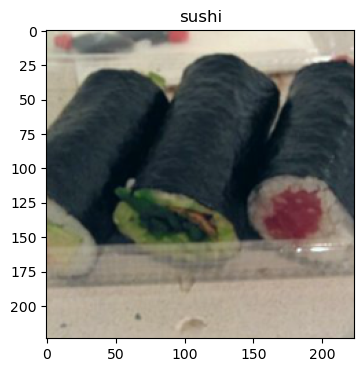

In [82]:
import matplotlib.pyplot as plt 
import numpy as np

if image.min() < 0 or image.max() > 1:
        image = (image - image.min()) / (image.max() - image.min())
plt.figure(figsize=(4,4))
plt.imshow(image.permute(1, 2, 0))
plt.title(f'{class_names[lab]}')

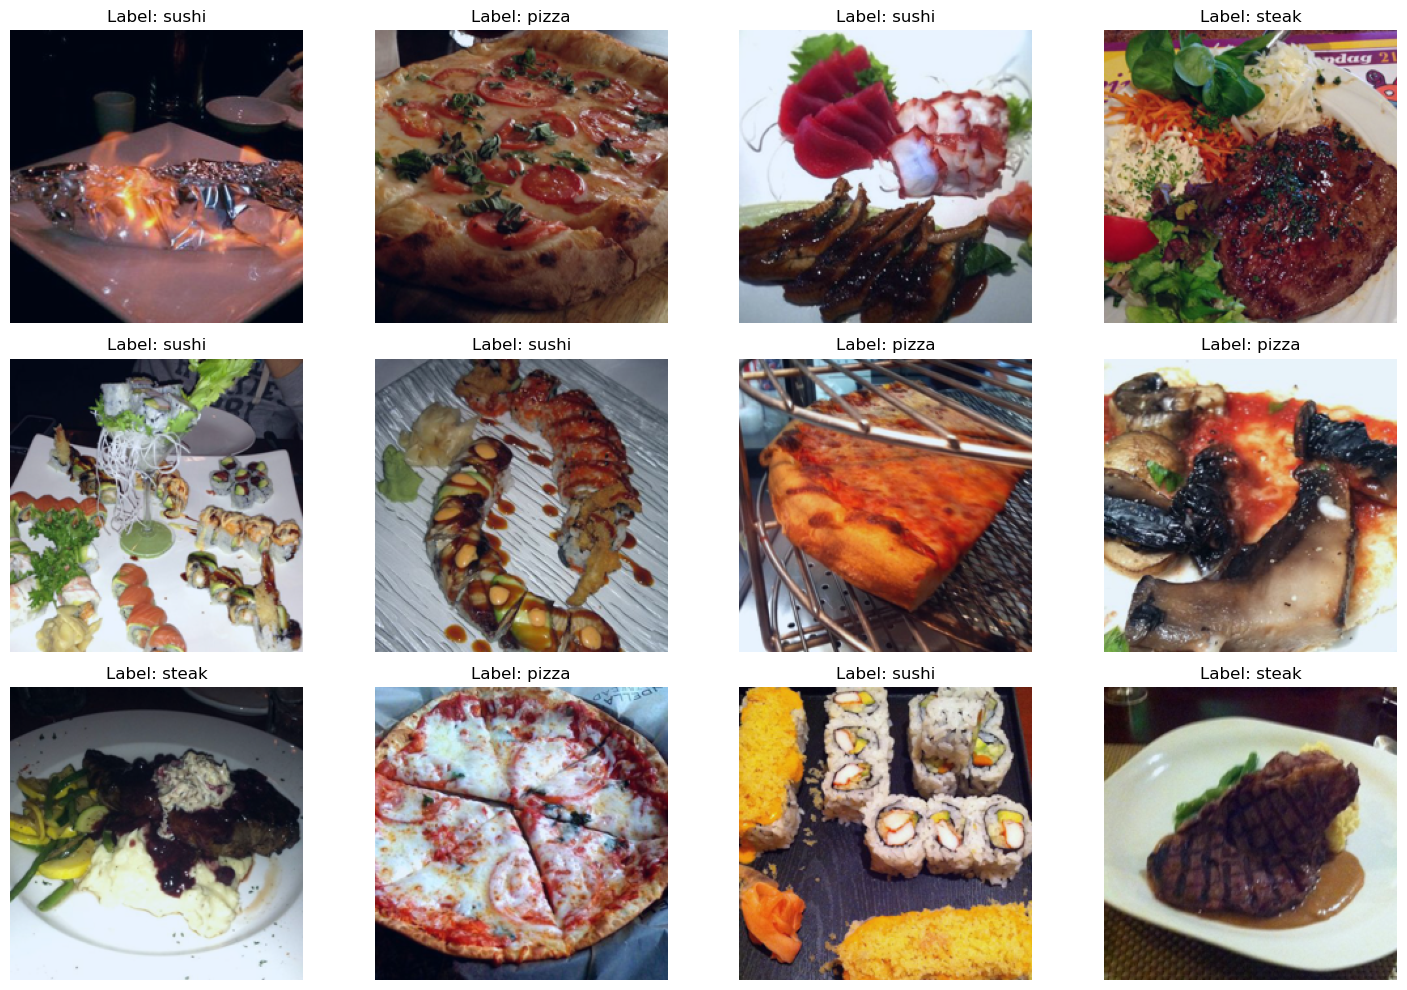

In [83]:
if isinstance(img, torch.Tensor):
    images = img.numpy()
    images = np.transpose(images, (0, 2, 3, 1))
batch_size = images.shape[0]
num_images = min(12, batch_size)  
random_indices = np.random.choice(batch_size, num_images, replace=False)
plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(3, 4, i+1)  # 3 rows, 4 columns
    image = images[idx]
    label = labels[idx]
    
    # If image is normalized, undo the normalization for visualization
    if image.min() < 0 or image.max() > 1:
        image = (image - image.min()) / (image.max() - image.min())
    
    plt.imshow(image)
    plt.title(f"Label: {class_names[label]}" if class_names else f"Class: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()
    

## 3. Define several models to train and log the performance

In [109]:
import torchvision
from torch import nn
import torch

def create_model(model_name, out_features, device):
    """
    Factory function to create different pretrained models with consistent interface.
    """
    model_creators = {
        "effnetb0": create_effnetb0,
        "effnetb2": create_effnetb2,
        "resnet50": create_resnet50,
        "vit_b_16": create_vit_b_16,
        "convnext_tiny": create_convnext_tiny,
        "mobilenet_v3": create_mobilenet_v3,
        "densenet121": create_densenet121,
        "swin_t": create_swin_t
    }
    
    if model_name not in model_creators:
        raise ValueError(f"Model {model_name} not supported. Choose from: {list(model_creators.keys())}")
    
    return model_creators[model_name](out_features, device)

# EfficientNet Models
def create_effnetb0(out_features, device):
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)
    
    # Freeze base layers
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Modify classifier
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=out_features)
    ).to(device)
    
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

def create_effnetb2(out_features, device):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)
    
    for param in model.features.parameters():
        param.requires_grad = False
    
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=out_features)
    ).to(device)
    
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

# ResNet50
def create_resnet50(out_features, device):
    weights = torchvision.models.ResNet50_Weights.DEFAULT
    model = torchvision.models.resnet50(weights=weights).to(device)
    
    # Freeze base layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Modify classifier (resnet uses fc instead of classifier)
    model.fc = nn.Linear(in_features=2048, out_features=out_features).to(device)
    
    model.name = "resnet50"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Vision Transformer (ViT)
def create_vit_b_16(out_features, device):
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    model = torchvision.models.vit_b_16(weights=weights).to(device)
    
    # Freeze base layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Modify head
    model.heads = nn.Sequential(
        nn.Linear(in_features=768, out_features=out_features)
    ).to(device)
    
    model.name = "vit_b_16"
    print(f"[INFO] Created new {model.name} model.")
    return model

# ConvNeXt (Modern ConvNet)
def create_convnext_tiny(out_features, device):
    weights = torchvision.models.ConvNeXt_Tiny_Weights.DEFAULT
    model = torchvision.models.convnext_tiny(weights=weights).to(device)
    
    # Freeze base layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Modify classifier
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=768, out_features=out_features)
    ).to(device)
    
    model.name = "convnext_tiny"
    print(f"[INFO] Created new {model.name} model.")
    return model

# MobileNetV3 (Lightweight)
def create_mobilenet_v3(out_features, device):
    weights = torchvision.models.MobileNet_V3_Small_Weights.DEFAULT
    model = torchvision.models.mobilenet_v3_small(weights=weights).to(device)
    
    # Freeze base layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Modify classifier
    model.classifier = nn.Sequential(
        nn.Linear(in_features=576, out_features=out_features)
    ).to(device)
    
    model.name = "mobilenet_v3"
    print(f"[INFO] Created new {model.name} model.")
    return model

# DenseNet121
def create_densenet121(out_features, device):
    weights = torchvision.models.DenseNet121_Weights.DEFAULT
    model = torchvision.models.densenet121(weights=weights).to(device)
    
    # Freeze base layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Modify classifier
    model.classifier = nn.Linear(in_features=1024, out_features=out_features).to(device)
    
    model.name = "densenet121"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Swin Transformer
def create_swin_t(out_features, device):
    weights = torchvision.models.Swin_T_Weights.DEFAULT
    model = torchvision.models.swin_t(weights=weights).to(device)
    
    # Freeze base layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Modify head
    model.head = nn.Linear(in_features=768, out_features=out_features).to(device)
    
    model.name = "swin_t"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [110]:
from torch.utils.tensorboard.writer import SummaryWriter

In [111]:
from typing import Dict, List, Optional
from tqdm.auto import tqdm
from datetime import datetime
import os
import torch
from torch.utils.tensorboard import SummaryWriter


def train_model(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device,
    writer: Optional[SummaryWriter] = None,
    early_stopping_patience: Optional[int] = None
) -> Dict[str, List[float]]:
    """Trains and evaluates a PyTorch model with TensorBoard logging.
    
    Args:
        model: PyTorch model to train.
        train_dataloader: DataLoader for training data.
        test_dataloader: DataLoader for test/validation data.
        optimizer: Optimization algorithm.
        loss_fn: Loss function.
        epochs: Maximum number of training epochs.
        device: Target device ("cuda" or "cpu").
        writer: TensorBoard SummaryWriter for logging.
        early_stopping_patience: Number of epochs to wait before stopping if no improvement.
        
    Returns:
        Dictionary containing training and test metrics:
        {
            'train_loss': [...], 
            'train_acc': [...],
            'test_loss': [...],
            'test_acc': [...]
        }
    """
    # Initialize results dictionary
    results = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }
    
    # Early stopping initialization
    best_test_loss = float('inf')
    epochs_without_improvement = 0
    
    for epoch in tqdm(range(epochs), desc="Training Progress"):
        # Training phase
        model.train()
        train_loss, train_correct = 0.0, 0
        total_samples = 0
        
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            batch_size = X.size(0)
            total_samples += batch_size
            
            # Forward pass
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            train_loss += loss.item() * batch_size
            
            # Calculate accuracy
            _, predicted = torch.max(y_pred.data, 1)
            train_correct += (predicted == y).sum().item()
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Calculate training metrics
        train_loss /= total_samples
        train_acc = train_correct / total_samples
        
        # Evaluation phase
        test_loss, test_acc = evaluate_model(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device
        )
        
        # Store results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        # Print metrics
        print(
            f"Epoch: {epoch+1}/{epochs} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Train Acc: {train_acc:.4f} | "
            f"Test Loss: {test_loss:.4f} | "
            f"Test Acc: {test_acc:.4f}"
        )
        
        # TensorBoard logging
        if writer:
            # Scalars
            writer.add_scalars(
                'Loss',
                {'train': train_loss, 'test': test_loss},
                epoch
            )
            writer.add_scalars(
                'Accuracy', 
                {'train': train_acc, 'test': test_acc},
                epoch
            )
            
            # Histograms (less frequent to reduce overhead)
            if epoch == 0 or (epoch + 1) % 5 == 0:
                for name, param in model.named_parameters():
                    writer.add_histogram(f'weights/{name}', param, epoch)
                    if param.grad is not None:
                        writer.add_histogram(f'grads/{name}', param.grad, epoch)
            
            writer.flush()
        
        # Early stopping check
        if early_stopping_patience:
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= early_stopping_patience:
                    print(f"\nEarly stopping triggered at epoch {epoch+1}")
                    break
    
    return results


def evaluate_model(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device
) -> tuple[float, float]:
    """Evaluates model performance on a given dataset.
    
    Args:
        model: PyTorch model to evaluate.
        dataloader: DataLoader for evaluation data.
        loss_fn: Loss function.
        device: Target device ("cuda" or "cpu").
        
    Returns:
        Tuple of (loss, accuracy) metrics.
    """
    model.eval()
    total_loss, total_correct = 0.0, 0
    total_samples = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            batch_size = X.size(0)
            total_samples += batch_size
            
            y_pred = model(X)
            total_loss += loss_fn(y_pred, y).item() * batch_size
            
            _, predicted = torch.max(y_pred.data, 1)
            total_correct += (predicted == y).sum().item()
    
    return total_loss / total_samples, total_correct / total_samples


def create_experiment_writer(
    experiment_name: str,
    model_name: str,
    hyperparameters: Optional[Dict] = None,
    extra: Optional[str] = None
) -> SummaryWriter:
    """Creates a TensorBoard SummaryWriter with organized log directory structure.
    
    Directory structure: runs/YYYY-MM-DD/experiment_name/model_name/[hyperparameters]/[extra]
    
    Args:
        experiment_name: Name of the experiment.
        model_name: Name of the model architecture.
        hyperparameters: Dictionary of hyperparameters to include in path.
        extra: Any additional information to append to path.
        
    Returns:
        Configured SummaryWriter instance.
    """
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    
    # Build log directory path
    path_parts = ['runs', timestamp, experiment_name, model_name]
    
    # Add hyperparameters if provided
    if hyperparameters:
        hyper_str = '_'.join(f'{k}_{v}' for k, v in sorted(hyperparameters.items()))
        path_parts.append(hyper_str)
    
    # Add extra information if provided
    if extra:
        path_parts.append(extra)
    
    log_dir = os.path.join(*path_parts)
    
    print(f'[INFO] Created TensorBoard writer at: {log_dir}')
    return SummaryWriter(log_dir=log_dir)

## 4. Run the Experiment

In [112]:
import os
from datetime import datetime

# Create a directory for saved models
model_save_dir = "saved_models"
os.makedirs(model_save_dir, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
OUT_FEATURES = len(class_names)

# List of models to compare
models_to_test = ["effnetb0", "effnetb2", "resnet50", "vit_b_16", "convnext_tiny"]

# Experiment configuration
experiment_configs = [
    {"epochs": 5, "extra_tag": "5_epochs"},
    {"epochs": 10, "extra_tag": "10_epochs"}
]

# Common hyperparameters
base_hyperparams = {
    "lr": 0.001,
    "batch_size": 32,
    "optim": "Adam"
}

# Dictionary to store all results and best models
all_results = {}
best_models = {"best_test_acc": 0, "model": None, "name": "", "config": {}}

for model_name in models_to_test:
    model_results = {}
    for config in experiment_configs:
        epochs = config["epochs"]
        extra_tag = config["extra_tag"]
        
        print(f"\n=== Training {model_name} for {epochs} epochs ===")
        
        # Create model
        model = create_model(model_name, OUT_FEATURES, device)
        
        # Initialize writer
        writer = create_experiment_writer(
            experiment_name="food_classification",
            model_name=model.name,
            hyperparameters={**base_hyperparams, "epochs": epochs},
            extra=extra_tag
        )
        
        optimizer = torch.optim.Adam(model.parameters(), lr=base_hyperparams["lr"])
        loss_fn = nn.CrossEntropyLoss()
        
        # Train model and get results
        results = train_model(
            model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=epochs,
            device=device,
            writer=writer,
            early_stopping_patience=3
        )
        
        # Save results
        model_results[extra_tag] = results
        
        # Save the model
        model_save_path = os.path.join(
            model_save_dir,
            f"{model.name}_{extra_tag}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pt"
        )
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'test_acc': results['test_acc'][-1],
            'config': config
        }, model_save_path)
        print(f"Model saved to {model_save_path}")
        
        # Update best model
        current_test_acc = max(results['test_acc'])
        if current_test_acc > best_models["best_test_acc"]:
            best_models = {
                "best_test_acc": current_test_acc,
                "model": model,
                "name": model.name,
                "config": config,
                "path": model_save_path
            }
        
        writer.close()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    all_results[model_name] = model_results

# Print summary of best model
print("\n=== Training Summary ===")
print(f"Best model: {best_models['name']}")
print(f"Configuration: {best_models['config']}")
print(f"Best test accuracy: {best_models['best_test_acc']:.4f}")
print(f"Saved at: {best_models['path']}")

# Save the best model separately
best_model_path = os.path.join(model_save_dir, "best_model.pt")
torch.save({
    'model_state_dict': best_models['model'].state_dict(),
    'test_acc': best_models['best_test_acc'],
    'config': best_models['config']
}, best_model_path)
print(f"\nBest model saved to {best_model_path}")


=== Training effnetb0 for 5 epochs ===
[INFO] Created new effnetb0 model.
[INFO] Created TensorBoard writer at: runs\2025-05-19_17-40-27\food_classification\effnetb0\batch_size_32_epochs_5_lr_0.001_optim_Adam\5_epochs


Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1/5 | Train Loss: 0.6522 | Train Acc: 0.7935 | Test Loss: 0.3388 | Test Acc: 0.9057
Epoch: 2/5 | Train Loss: 0.3968 | Train Acc: 0.8748 | Test Loss: 0.2462 | Test Acc: 0.9245
Epoch: 3/5 | Train Loss: 0.3380 | Train Acc: 0.8873 | Test Loss: 0.2142 | Test Acc: 0.9353
Epoch: 4/5 | Train Loss: 0.2980 | Train Acc: 0.8990 | Test Loss: 0.2057 | Test Acc: 0.9380
Epoch: 5/5 | Train Loss: 0.2785 | Train Acc: 0.8990 | Test Loss: 0.1913 | Test Acc: 0.9434
Model saved to saved_models\effnetb0_5_epochs_20250519_174607.pt

=== Training effnetb0 for 10 epochs ===
[INFO] Created new effnetb0 model.
[INFO] Created TensorBoard writer at: runs\2025-05-19_17-46-07\food_classification\effnetb0\batch_size_32_epochs_10_lr_0.001_optim_Adam\10_epochs


Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10 | Train Loss: 0.6607 | Train Acc: 0.7792 | Test Loss: 0.3418 | Test Acc: 0.9111
Epoch: 2/10 | Train Loss: 0.3865 | Train Acc: 0.8806 | Test Loss: 0.2473 | Test Acc: 0.9272
Epoch: 3/10 | Train Loss: 0.3254 | Train Acc: 0.8950 | Test Loss: 0.2157 | Test Acc: 0.9367
Epoch: 4/10 | Train Loss: 0.2877 | Train Acc: 0.9017 | Test Loss: 0.1930 | Test Acc: 0.9420
Epoch: 5/10 | Train Loss: 0.2761 | Train Acc: 0.9093 | Test Loss: 0.1894 | Test Acc: 0.9394
Epoch: 6/10 | Train Loss: 0.2503 | Train Acc: 0.9089 | Test Loss: 0.1807 | Test Acc: 0.9434
Epoch: 7/10 | Train Loss: 0.2491 | Train Acc: 0.9129 | Test Loss: 0.1712 | Test Acc: 0.9474
Epoch: 8/10 | Train Loss: 0.2437 | Train Acc: 0.9102 | Test Loss: 0.1703 | Test Acc: 0.9461
Epoch: 9/10 | Train Loss: 0.2318 | Train Acc: 0.9156 | Test Loss: 0.1588 | Test Acc: 0.9528
Epoch: 10/10 | Train Loss: 0.2223 | Train Acc: 0.9206 | Test Loss: 0.1602 | Test Acc: 0.9515
Model saved to saved_models\effnetb0_10_epochs_20250519_175735.pt

=== Training

Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1/5 | Train Loss: 0.7037 | Train Acc: 0.7518 | Test Loss: 0.4073 | Test Acc: 0.9178
Epoch: 2/5 | Train Loss: 0.4416 | Train Acc: 0.8636 | Test Loss: 0.2977 | Test Acc: 0.9245
Epoch: 3/5 | Train Loss: 0.3519 | Train Acc: 0.8914 | Test Loss: 0.2562 | Test Acc: 0.9313
Epoch: 4/5 | Train Loss: 0.3323 | Train Acc: 0.8824 | Test Loss: 0.2341 | Test Acc: 0.9353
Epoch: 5/5 | Train Loss: 0.3124 | Train Acc: 0.8887 | Test Loss: 0.2189 | Test Acc: 0.9394
Model saved to saved_models\effnetb2_5_epochs_20250519_180330.pt

=== Training effnetb2 for 10 epochs ===
[INFO] Created new effnetb2 model.
[INFO] Created TensorBoard writer at: runs\2025-05-19_18-03-31\food_classification\effnetb2\batch_size_32_epochs_10_lr_0.001_optim_Adam\10_epochs


Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10 | Train Loss: 0.7009 | Train Acc: 0.7576 | Test Loss: 0.4075 | Test Acc: 0.9218
Epoch: 2/10 | Train Loss: 0.4352 | Train Acc: 0.8627 | Test Loss: 0.3035 | Test Acc: 0.9313
Epoch: 3/10 | Train Loss: 0.3687 | Train Acc: 0.8761 | Test Loss: 0.2556 | Test Acc: 0.9313
Epoch: 4/10 | Train Loss: 0.3135 | Train Acc: 0.8936 | Test Loss: 0.2330 | Test Acc: 0.9299
Epoch: 5/10 | Train Loss: 0.2954 | Train Acc: 0.8927 | Test Loss: 0.2185 | Test Acc: 0.9353
Epoch: 6/10 | Train Loss: 0.2798 | Train Acc: 0.9053 | Test Loss: 0.2046 | Test Acc: 0.9461
Epoch: 7/10 | Train Loss: 0.2951 | Train Acc: 0.8990 | Test Loss: 0.1967 | Test Acc: 0.9474
Epoch: 8/10 | Train Loss: 0.2615 | Train Acc: 0.9075 | Test Loss: 0.1993 | Test Acc: 0.9447
Epoch: 9/10 | Train Loss: 0.2540 | Train Acc: 0.9066 | Test Loss: 0.1933 | Test Acc: 0.9434
Epoch: 10/10 | Train Loss: 0.2602 | Train Acc: 0.9098 | Test Loss: 0.1885 | Test Acc: 0.9380
Model saved to saved_models\effnetb2_10_epochs_20250519_181521.pt

=== Training

Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1/5 | Train Loss: 0.6876 | Train Acc: 0.8025 | Test Loss: 0.3964 | Test Acc: 0.9353
Epoch: 2/5 | Train Loss: 0.3870 | Train Acc: 0.8990 | Test Loss: 0.2660 | Test Acc: 0.9501
Epoch: 3/5 | Train Loss: 0.3111 | Train Acc: 0.9111 | Test Loss: 0.2153 | Test Acc: 0.9569
Epoch: 4/5 | Train Loss: 0.2760 | Train Acc: 0.9210 | Test Loss: 0.1916 | Test Acc: 0.9623
Epoch: 5/5 | Train Loss: 0.2355 | Train Acc: 0.9412 | Test Loss: 0.1722 | Test Acc: 0.9636
Model saved to saved_models\resnet50_5_epochs_20250519_182149.pt

=== Training resnet50 for 10 epochs ===
[INFO] Created new resnet50 model.
[INFO] Created TensorBoard writer at: runs\2025-05-19_18-21-49\food_classification\resnet50\batch_size_32_epochs_10_lr_0.001_optim_Adam\10_epochs


Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10 | Train Loss: 0.7185 | Train Acc: 0.7693 | Test Loss: 0.4065 | Test Acc: 0.9367
Epoch: 2/10 | Train Loss: 0.3877 | Train Acc: 0.9057 | Test Loss: 0.2760 | Test Acc: 0.9582
Epoch: 3/10 | Train Loss: 0.3048 | Train Acc: 0.9174 | Test Loss: 0.2266 | Test Acc: 0.9609
Epoch: 4/10 | Train Loss: 0.2686 | Train Acc: 0.9322 | Test Loss: 0.1906 | Test Acc: 0.9636
Epoch: 5/10 | Train Loss: 0.2447 | Train Acc: 0.9345 | Test Loss: 0.1700 | Test Acc: 0.9650
Epoch: 6/10 | Train Loss: 0.2172 | Train Acc: 0.9394 | Test Loss: 0.1561 | Test Acc: 0.9690
Epoch: 7/10 | Train Loss: 0.1923 | Train Acc: 0.9529 | Test Loss: 0.1418 | Test Acc: 0.9690
Epoch: 8/10 | Train Loss: 0.1873 | Train Acc: 0.9457 | Test Loss: 0.1382 | Test Acc: 0.9663
Epoch: 9/10 | Train Loss: 0.1652 | Train Acc: 0.9587 | Test Loss: 0.1243 | Test Acc: 0.9704
Epoch: 10/10 | Train Loss: 0.1667 | Train Acc: 0.9565 | Test Loss: 0.1291 | Test Acc: 0.9704
Model saved to saved_models\resnet50_10_epochs_20250519_183432.pt

=== Training

Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1/5 | Train Loss: 0.2866 | Train Acc: 0.9008 | Test Loss: 0.0954 | Test Acc: 0.9704
Epoch: 2/5 | Train Loss: 0.1210 | Train Acc: 0.9614 | Test Loss: 0.0792 | Test Acc: 0.9730
Epoch: 3/5 | Train Loss: 0.0960 | Train Acc: 0.9713 | Test Loss: 0.0756 | Test Acc: 0.9704
Epoch: 4/5 | Train Loss: 0.0812 | Train Acc: 0.9758 | Test Loss: 0.0675 | Test Acc: 0.9757
Epoch: 5/5 | Train Loss: 0.0680 | Train Acc: 0.9803 | Test Loss: 0.0665 | Test Acc: 0.9798
Model saved to saved_models\vit_b_16_5_epochs_20250519_184716.pt

=== Training vit_b_16 for 10 epochs ===
[INFO] Created new vit_b_16 model.
[INFO] Created TensorBoard writer at: runs\2025-05-19_18-47-18\food_classification\vit_b_16\batch_size_32_epochs_10_lr_0.001_optim_Adam\10_epochs


Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10 | Train Loss: 0.2896 | Train Acc: 0.8986 | Test Loss: 0.0969 | Test Acc: 0.9704
Epoch: 2/10 | Train Loss: 0.1227 | Train Acc: 0.9587 | Test Loss: 0.0828 | Test Acc: 0.9784
Epoch: 3/10 | Train Loss: 0.0993 | Train Acc: 0.9699 | Test Loss: 0.0718 | Test Acc: 0.9798
Epoch: 4/10 | Train Loss: 0.0812 | Train Acc: 0.9785 | Test Loss: 0.0655 | Test Acc: 0.9798
Epoch: 5/10 | Train Loss: 0.0691 | Train Acc: 0.9816 | Test Loss: 0.0669 | Test Acc: 0.9757
Epoch: 6/10 | Train Loss: 0.0598 | Train Acc: 0.9843 | Test Loss: 0.0630 | Test Acc: 0.9784
Epoch: 7/10 | Train Loss: 0.0519 | Train Acc: 0.9874 | Test Loss: 0.0613 | Test Acc: 0.9784
Epoch: 8/10 | Train Loss: 0.0462 | Train Acc: 0.9915 | Test Loss: 0.0593 | Test Acc: 0.9811
Epoch: 9/10 | Train Loss: 0.0412 | Train Acc: 0.9924 | Test Loss: 0.0601 | Test Acc: 0.9825
Epoch: 10/10 | Train Loss: 0.0363 | Train Acc: 0.9928 | Test Loss: 0.0583 | Test Acc: 0.9825
Model saved to saved_models\vit_b_16_10_epochs_20250519_191257.pt

=== Training

Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1/5 | Train Loss: 0.6750 | Train Acc: 0.8613 | Test Loss: 0.3459 | Test Acc: 0.9690
Epoch: 2/5 | Train Loss: 0.3505 | Train Acc: 0.9443 | Test Loss: 0.2089 | Test Acc: 0.9757
Epoch: 3/5 | Train Loss: 0.2593 | Train Acc: 0.9524 | Test Loss: 0.1571 | Test Acc: 0.9744
Epoch: 4/5 | Train Loss: 0.2180 | Train Acc: 0.9529 | Test Loss: 0.1290 | Test Acc: 0.9771
Epoch: 5/5 | Train Loss: 0.1848 | Train Acc: 0.9551 | Test Loss: 0.1127 | Test Acc: 0.9784
Model saved to saved_models\convnext_tiny_5_epochs_20250519_192028.pt

=== Training convnext_tiny for 10 epochs ===
[INFO] Created new convnext_tiny model.
[INFO] Created TensorBoard writer at: runs\2025-05-19_19-20-28\food_classification\convnext_tiny\batch_size_32_epochs_10_lr_0.001_optim_Adam\10_epochs


Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10 | Train Loss: 0.6564 | Train Acc: 0.8851 | Test Loss: 0.3381 | Test Acc: 0.9704
Epoch: 2/10 | Train Loss: 0.3478 | Train Acc: 0.9470 | Test Loss: 0.2051 | Test Acc: 0.9717
Epoch: 3/10 | Train Loss: 0.2577 | Train Acc: 0.9520 | Test Loss: 0.1559 | Test Acc: 0.9730
Epoch: 4/10 | Train Loss: 0.2146 | Train Acc: 0.9556 | Test Loss: 0.1284 | Test Acc: 0.9771
Epoch: 5/10 | Train Loss: 0.1859 | Train Acc: 0.9601 | Test Loss: 0.1123 | Test Acc: 0.9784
Epoch: 6/10 | Train Loss: 0.1651 | Train Acc: 0.9587 | Test Loss: 0.1012 | Test Acc: 0.9798
Epoch: 7/10 | Train Loss: 0.1560 | Train Acc: 0.9632 | Test Loss: 0.0925 | Test Acc: 0.9798
Epoch: 8/10 | Train Loss: 0.1456 | Train Acc: 0.9623 | Test Loss: 0.0865 | Test Acc: 0.9838
Epoch: 9/10 | Train Loss: 0.1354 | Train Acc: 0.9654 | Test Loss: 0.0823 | Test Acc: 0.9825
Epoch: 10/10 | Train Loss: 0.1286 | Train Acc: 0.9654 | Test Loss: 0.0788 | Test Acc: 0.9825
Model saved to saved_models\convnext_tiny_10_epochs_20250519_193505.pt

=== Tra

## 5. Let's Use tensorboard to see the results

In [113]:
%reload_ext tensorboard 
%tensorboard --logdir=runs --port=6006

Reusing TensorBoard on port 6006 (pid 16164), started 2:27:17 ago. (Use '!kill 16164' to kill it.)

## 6. Load in the best model and make predictions with it.

In [140]:
# Setup the best model filepath 
best_model_path = 'saved_models/convnext_tiny_10_epochs_20250519_193505.pt'

checkpoint = torch.load(best_model_path, map_location=device)
best_model = create_convnext_tiny(out_features=3, device=device)  # or whatever model you saved
best_model.load_state_dict(checkpoint['model_state_dict'])
best_model.eval()  # Put in evaluation mode


C:\Users\yashs\AppData\Local\Temp\ipykernel_27312\2746604141.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=device

[INFO] Created new convnext_tiny model.


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [141]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

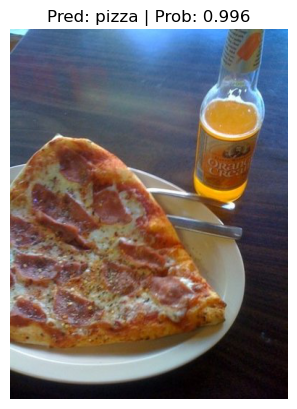

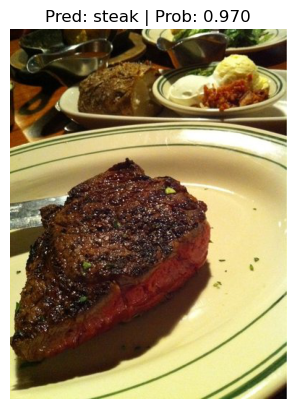

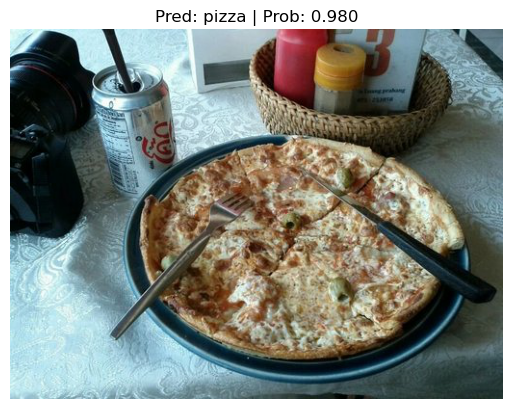

In [148]:
# Get a random list of 3 images from 20% test set
import random
from pathlib import Path 

num_images_to_plot = 3
test_image_path_list = list(Path('data/pizza_steak_sushi_99/test').glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

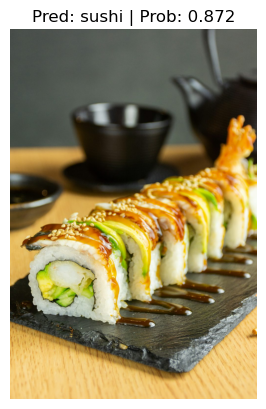

In [149]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/sushi.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://images.unsplash.com/photo-1582450871972-ab5ca641643d?w=1000&auto=format&fit=crop&q=60&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxzZWFyY2h8MjB8fHN1c2hpfGVufDB8fDB8fHww")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)